In [184]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Pair Programming Decision Tree

### Ana G y Ana C

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Decision Tree en este tipo de problemas. 

Los objetivos de este pair programming :

- Ajustad un modelo de Decision Tree a nuestros datos.
-Calculad las métricas a nuestro nuevo modelo.
-Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [185]:
df_cod_noest = pd.read_csv("../data-log/02-df_codifcadas_no_estandarizadas.csv",index_col=0)
df_cod_noest.head()

,id,sex,education,age,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,glucose,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,0.0,1,2.0,64.0,1,3.0,0.0,0.0,0.0,0.0,80.0,221.0,148.0,85.0,26.060925,90.0,1.0
1,2.0,1,1.0,46.0,1,10.0,0.0,0.0,0.0,0.0,94.0,250.0,116.0,71.0,20.350000,88.0,0.0
2,4.0,1,1.0,64.0,1,30.0,0.0,0.0,0.0,0.0,77.0,241.0,136.5,85.0,26.420000,70.0,0.0
3,7.0,0,4.0,36.0,1,35.0,0.0,0.0,0.0,0.0,63.0,295.0,102.0,68.0,28.150000,60.0,0.0
4,8.0,1,2.0,41.0,1,20.0,0.0,0.0,0.0,0.0,79.0,220.0,126.0,78.0,20.700000,86.0,0.0


In [186]:
df_cod_noest.drop('id',axis=1, inplace=True)

In [187]:
df_cod_esta = pd.read_csv("../data-log/02-df_estandarizadas_codificadas.csv",index_col=0)
df_cod_esta.head()

,id,sex,education,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,TenYearCHD,age,cigsPerDay,glucose,totChol,sysBP,diaBP,BMI,heartRate
0,0.0,1,2.0,1,0.0,0.0,0.0,0.0,1.0,1.071429,0.15,0.153846,-0.224138,0.722222,0.193548,0.136595,1.000000
1,2.0,1,1.0,1,0.0,0.0,0.0,0.0,0.0,-0.214286,0.50,1.230769,0.275862,-0.462963,-0.709677,-1.009027,0.866667
2,4.0,1,1.0,1,0.0,0.0,0.0,0.0,0.0,1.071429,1.50,-0.076923,0.120690,0.296296,0.193548,0.208626,-0.333333
3,7.0,0,4.0,1,0.0,0.0,0.0,0.0,0.0,-0.928571,1.75,-1.153846,1.051724,-0.981481,-0.903226,0.555667,-1.000000
4,8.0,1,2.0,1,0.0,0.0,0.0,0.0,0.0,-0.571429,1.00,0.076923,-0.241379,-0.092593,-0.258065,-0.938816,0.733333


In [188]:
df_cod_esta.drop('id',axis=1, inplace=True)

In [189]:
df_bal = pd.read_csv("../data-log/02-bal_est_cod.csv",index_col=0)
df_bal.head()

,sex,education,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,glucose,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.857143,0.0,0.000000,0.206897,-0.166667,-0.774194,0.050150,-1.333333,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.0,-1.000000,0.620690,1.185185,1.580645,0.992979,0.000000,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.571429,0.0,0.000000,-0.637931,-0.277778,0.129032,-0.463390,0.333333,0.0
3,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,-0.307692,1.396552,1.018519,0.516129,0.108325,-0.733333,0.0
4,0.0,2.0,1.0,0.0,0.0,1.0,0.0,-0.500000,1.5,0.769231,0.620690,0.037037,1.161290,0.952859,0.466667,1.0


In [190]:
df_bal.dropna(inplace=True)

In [191]:

df_bal.shape

(2906, 16)

---

# 1. Datos  NO estandarizadas, no balanceado,codificadas

In [192]:
# separamos los datos en X e y
X1 = df_cod_noest.drop("TenYearCHD", axis = 1)
y1 = df_cod_noest["TenYearCHD"]

In [193]:
# separamos en train y test
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [194]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)
# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train1, y_train1)

DecisionTreeClassifier(random_state=0)

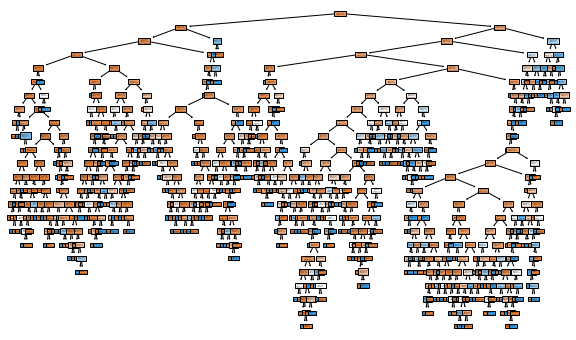

In [195]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train1.columns, filled = True)
plt.show()

In [196]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 
max_features = np.sqrt(len(x_train1.columns))
max_features

3.872983346207417

In [197]:
# max depth
print(arbol.tree_.max_depth)

23


In [198]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [199]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [200]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree NO Esta I")
dt_results1

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I


In [201]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [202]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla


In [203]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [204]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=2, max_features=4, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

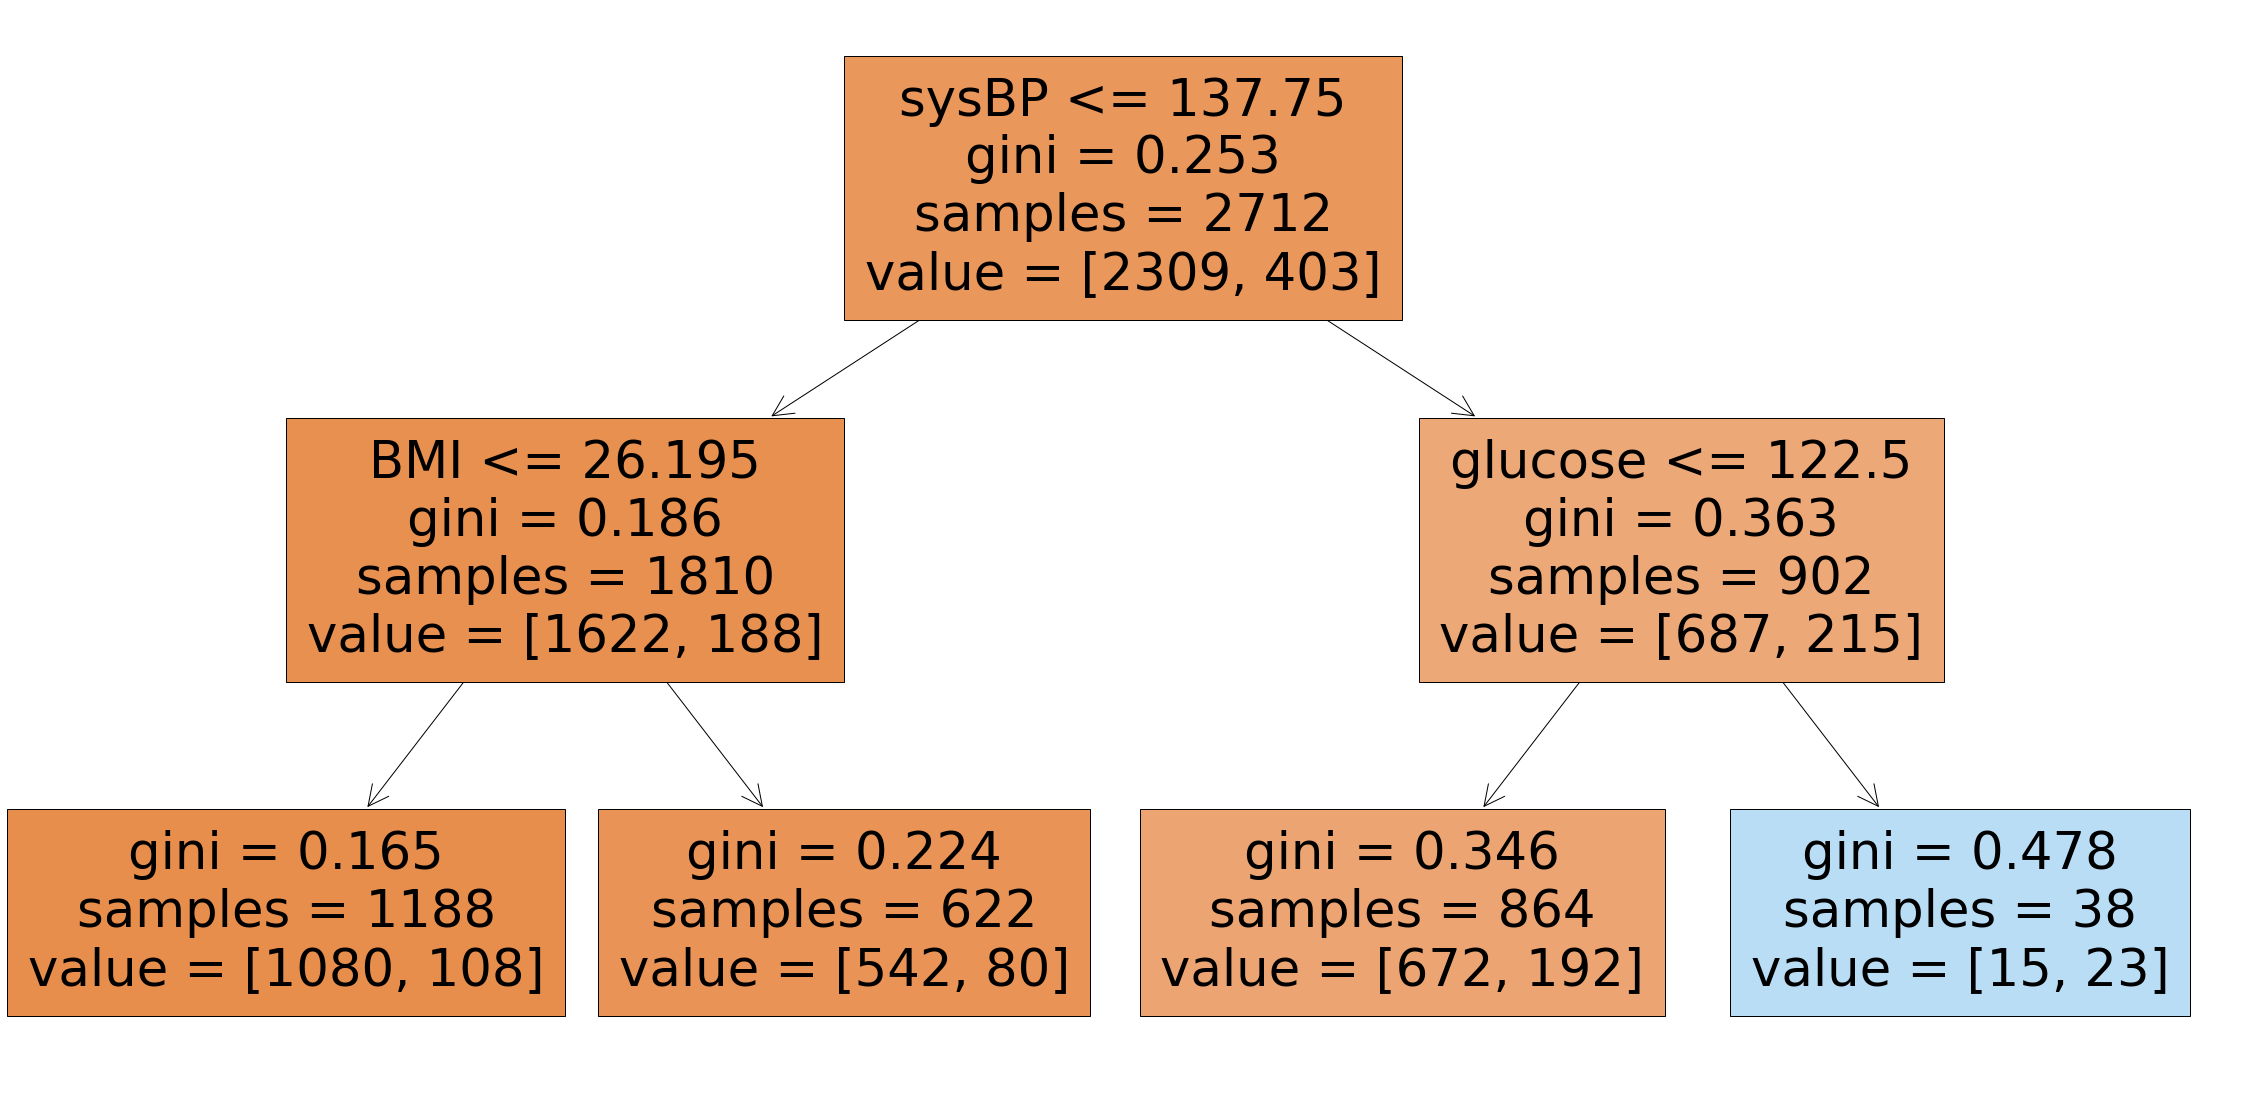

In [205]:
# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train1.columns, filled=True);

In [206]:
y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [207]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "DecisionTree NO Esta II")
dt_results2



,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
1,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [208]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
0,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
1,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [209]:
# si recodáis, en la clase de métricas guardamos en un csv los resultados de las métricas del modelo
# vamos a cargar ese csv para comparar todos los modelos que hemos hecho, y comparar cuál de ellos es el mejor

df_logistic_results = pd.read_csv("../data-log/04-df_metricas_resultados.csv", index_col=0)
df_logistic_results


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
0,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
1,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
0,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
1,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada


In [210]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_logistic_results, df_decision_results], axis = 0).reset_index(drop=True)
df_DT_LR_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [211]:
# pongamos un poco de color a nuestro dataframe para ver la comparación de los datos de una forma un poco más amigable. 
df_DT_LR_results.style.background_gradient(cmap='seismic')


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada Codificada
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada Codificada
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [212]:
# ademas vamos a guardar este dataframe en un csv para 

df_DT_LR_results.to_csv("../data-log/06-resultados_DTNOEsta_LR_DT.csv")

---

# 2. Estandarizadas y no balanceado,codificadas

In [213]:
# separamos los datos en X e y

X2 = df_cod_esta.drop("TenYearCHD", axis = 1)
y2 = df_cod_esta["TenYearCHD"]

In [214]:
# separamos en train y test
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [215]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)
# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train2, y_train2)

DecisionTreeClassifier(random_state=0)

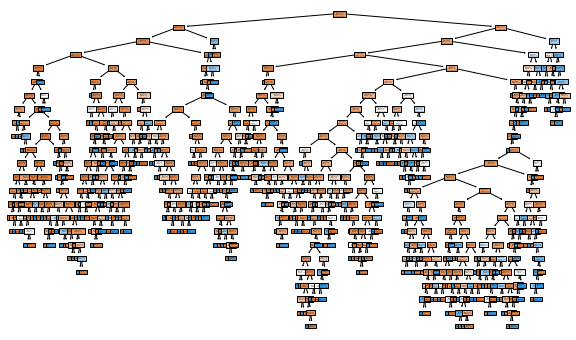

In [216]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train1.columns, filled = True)
plt.show()

In [217]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 
max_features = np.sqrt(len(x_train2.columns))
max_features

3.872983346207417

In [218]:
# max depth
print(arbol.tree_.max_depth)

23


In [219]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test2)
y_pred_train_esta = arbol.predict(x_train2)

In [220]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados
dt_results2 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree Esta I")
dt_results2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.733038,0.212598,0.25,0.229787,0.069599,test,Decission Tree Esta I
1,1.000000,1.000000,1.00,1.000000,1.000000,train,Decission Tree Esta I


In [221]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param2 = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [222]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs2 = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param2, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla


In [223]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs2.fit(x_train2, y_train2)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [224]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo2 = gs2.best_estimator_
mejor_modelo2

DecisionTreeClassifier(max_depth=2, max_features=4, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

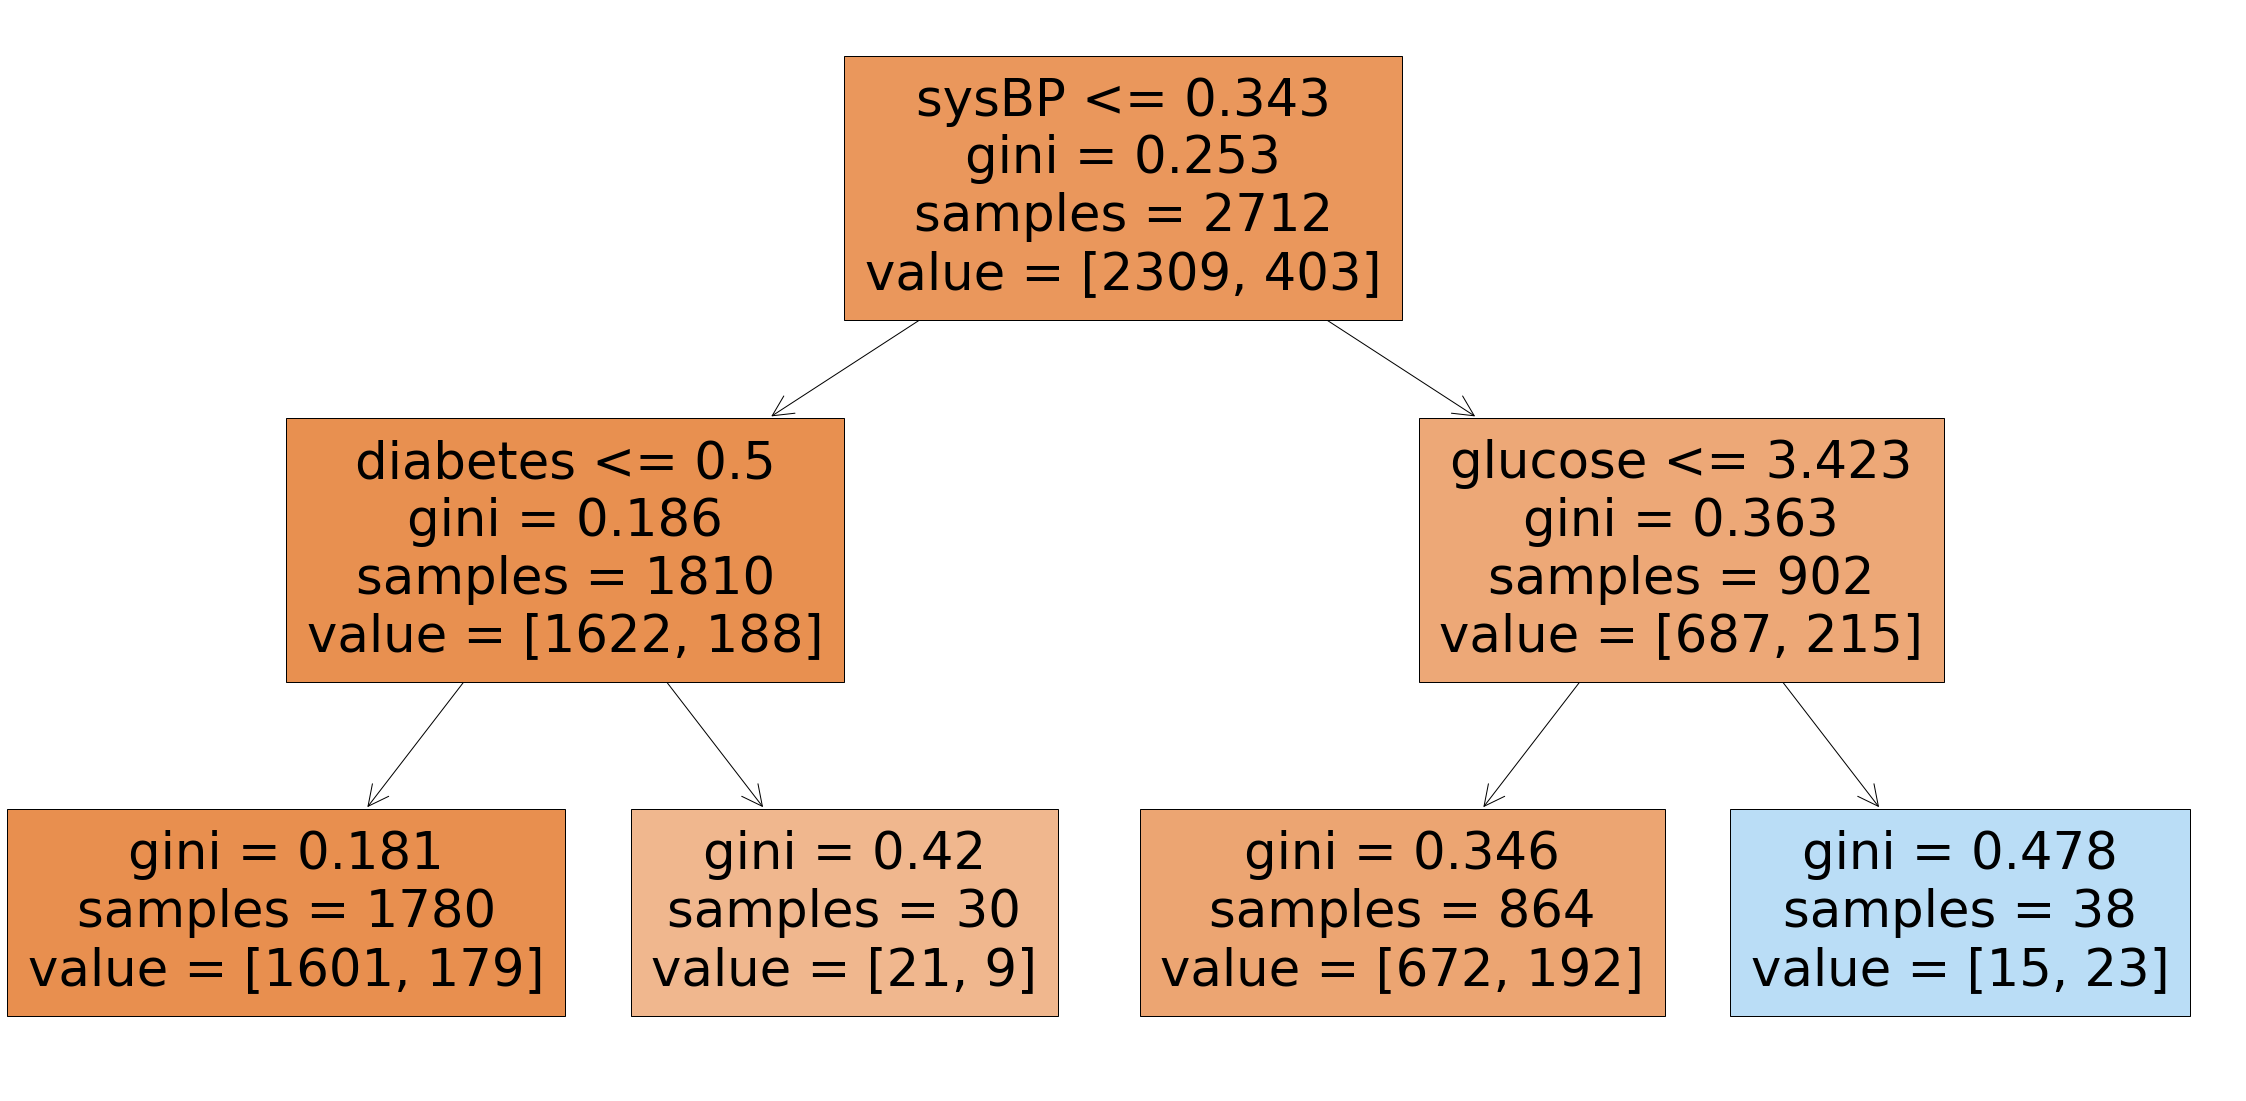

In [225]:
# veamos ahora que pinta tiene nuestro árbol

fig2 = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo2, feature_names=x_train2.columns, filled=True);

In [226]:
y_pred_test_esta3 = mejor_modelo2.predict(x_test2)
y_pred_train_esta3 = mejor_modelo2.predict(x_train2)

In [227]:
dt_results3 = metricas(y_test2, y_pred_test_esta2, y_train2,  y_pred_train_esta2, "DecisionTree Esta II")
dt_results3



,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree Esta II
1,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree Esta II


In [228]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results2, dt_results3], axis = 0)
df_decision_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.733038,0.212598,0.250000,0.229787,0.069599,test,Decission Tree Esta I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
0,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree Esta II
1,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree Esta II


In [255]:
# si recodáis, en la clase de métricas guardamos en un csv los resultados de las métricas del modelo
# vamos a cargar ese csv para comparar todos los modelos que hemos hecho, y comparar cuál de ellos es el mejor

df_logistic_results = pd.read_csv("../data-log/06-resultados_DTNOEsta_LR_DT.csv",index_col=0)
df_logistic_results


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [256]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_logistic_results, df_decision_results], axis = 0).reset_index(drop=True)
df_DT_LR_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [257]:
# pongamos un poco de color a nuestro dataframe para ver la comparación de los datos de una forma un poco más amigable. 
df_DT_LR_results.style.background_gradient(cmap='seismic')


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada Codificada
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada Codificada
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [258]:
# ademas vamos a guardar este dataframe en un csv para 

df_DT_LR_results.to_csv("../data-log/06-resultados_DTNOEsta_LR_DT.csv")

---

# 3. Balanceada, estandarizadas, codificadas

In [233]:
df_bal.dropna(inplace=True)

In [234]:
# separamos los datos en X e y

X3 = df_bal.drop("TenYearCHD", axis = 1)
y3 = df_bal["TenYearCHD"]

In [235]:
# separamos en train y test
x_train3, x_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 42)

In [236]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol3 = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol3.fit(x_train3, y_train3)



DecisionTreeClassifier(random_state=0)

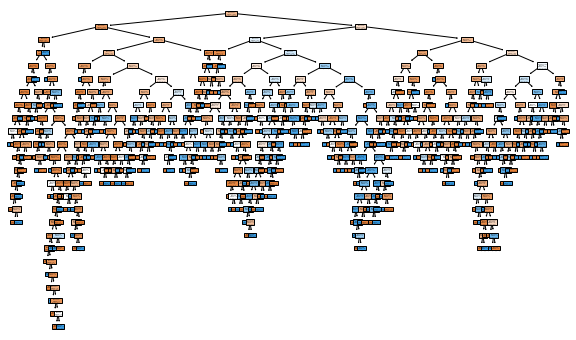

In [237]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol3, feature_names = x_train3.columns, filled = True)
plt.show()

In [238]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 4. 

max_features3 = np.sqrt(len(x_train3.columns))
max_features3

3.872983346207417

In [239]:

# max depth

print(arbol3.tree_.max_depth)

24


In [240]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta3 = arbol3.predict(x_test3)
y_pred_train_esta3 = arbol3.predict(x_train3)

In [241]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results4 = metricas(y_test3, y_pred_test_esta3, y_train3, y_pred_train_esta3, "Decission Tree Balanceada I")
dt_results4

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.774914,0.637931,0.620112,0.628895,0.467413,test,Decission Tree Balanceada I
1,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Balanceada I


In [242]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param3 = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [243]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs3 = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param3, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla

In [244]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs3.fit(x_train3, y_train3)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [245]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo3 = gs3.best_estimator_
mejor_modelo3

DecisionTreeClassifier(max_depth=12, max_features=4, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

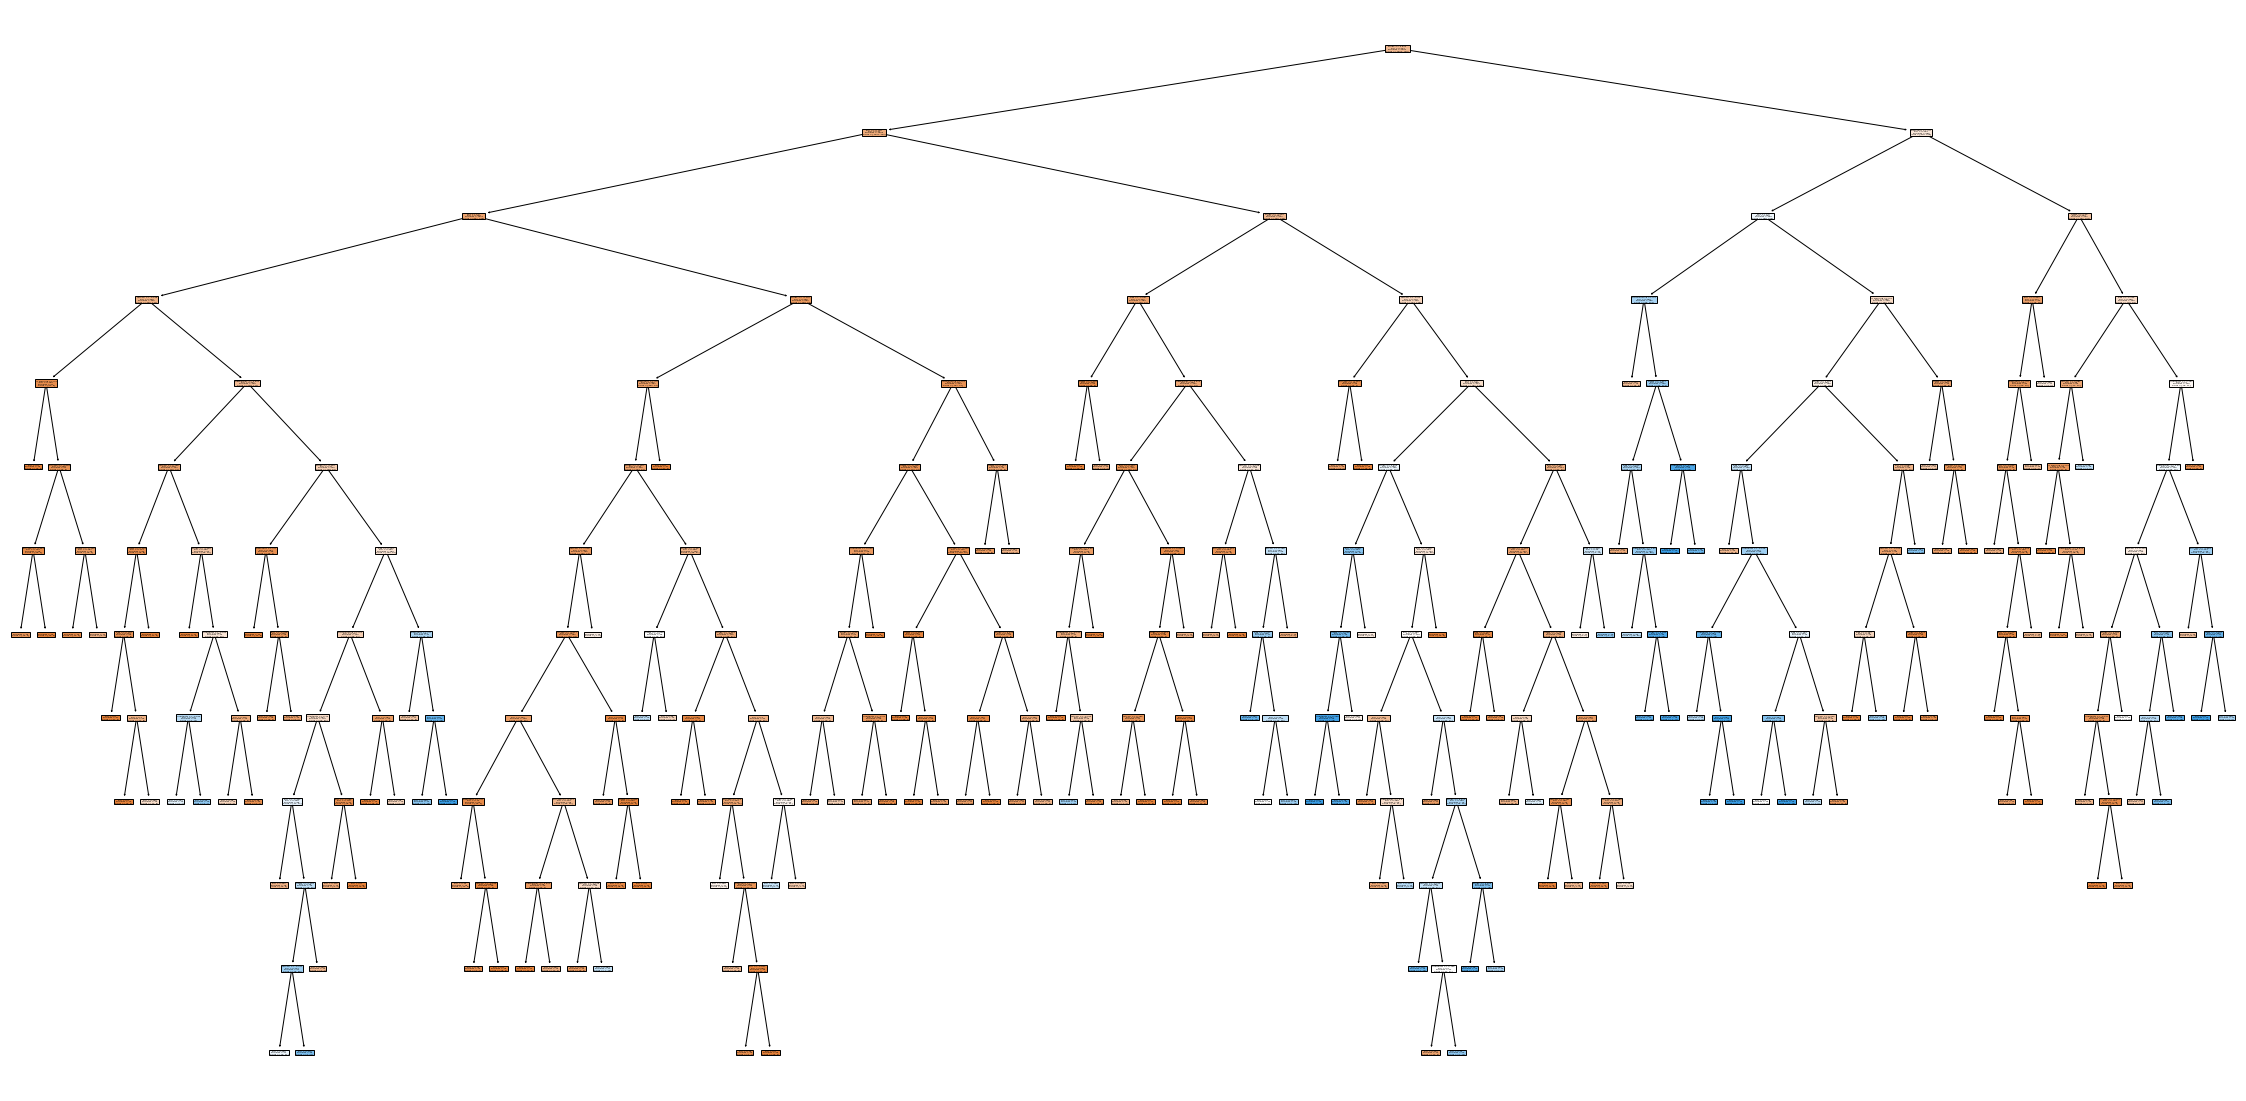

In [246]:
# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo3, feature_names=x_train3.columns, filled=True);

In [247]:
y_pred_test_esta3 = mejor_modelo3.predict(x_test3)
y_pred_train_esta3 = mejor_modelo3.predict(x_train3)

In [259]:
# si recodáis, en la clase de métricas guardamos en un csv los resultados de las métricas del modelo
# vamos a cargar ese csv para comparar todos los modelos que hemos hecho, y comparar cuál de ellos es el mejor

df_logistic_results2 = pd.read_csv("../data-log/06-resultados_DTNOEsta_LR_DT.csv", index_col=0)
df_logistic_results2


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [260]:
# concatenamos todos los resultados

df_DT_LR_results3 = pd.concat([df_logistic_results2, dt_results4], axis = 0).reset_index(drop=True)
df_DT_LR_results3

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [261]:
# pongamos un poco de color a nuestro dataframe para ver la comparación de los datos de una forma un poco más amigable. 
df_DT_LR_results3.style.background_gradient(cmap='seismic')


,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada Codificada
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada Codificada
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


Seguimos quedándonos con el modelo de Regresión Logistica con la variable respuesta balanceada, y las predictoras codificadas estandarizadas. Pero, sólo según las métricas, en nuestro caso, la gestión de nulos se hizo borrando directamente registros.
Valoramos que igual, es más fiable el resultado inmediatamente mejor, regresión logistica estandarizada, codificada. En cualquier caso, ambas, tienen un valor de kappa demasiado pequeño.

---

# Importancia de las predictoras

In [252]:

# vamos a crearnos un dataframe 
importancia_predictores_esta = pd.DataFrame(
                            {'predictor': x_train1.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores_esta.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_esta


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
11,sysBP,0.647769
9,glucose,0.317698
13,BMI,0.034533
0,sex,0.000000
1,education,0.000000
2,age,0.000000
3,is_smoking,0.000000
4,cigsPerDay,0.000000
5,BPMeds,0.000000
6,prevalentStroke,0.000000


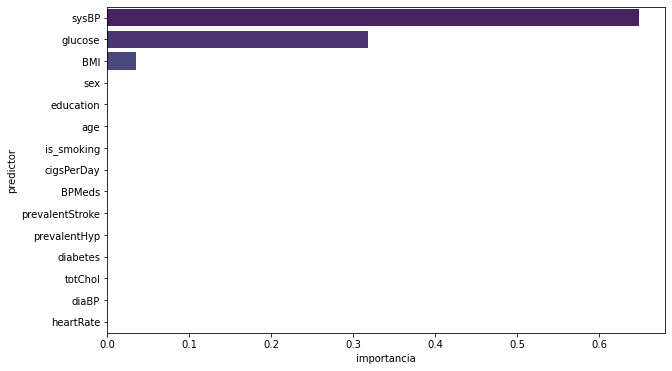

In [253]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_esta, palette="viridis");
plt.show()

In [262]:
df_DT_LR_results3.to_csv('../data-log/05-Metricas_Decision_Tree.csv')